In [80]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [81]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [82]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [83]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [84]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9488,1696435200,1.05249,1.05255,1.05111,1.05150,4156,9,0
9489,1696437000,1.05150,1.05172,1.05049,1.05067,5986,9,0
9490,1696438800,1.05067,1.05113,1.04826,1.04842,10718,9,0
9491,1696440600,1.04842,1.04995,1.04842,1.04924,6437,9,0


In [85]:

def trixcalc(df, lookBack=50, signalLookback=20):
    trix = ta.momentum.trix(close=df['close'], length=lookBack, signal=signalLookback)
    df['trix'] = trix[f'TRIX_{lookBack}_{signalLookback}']
    df['trixsignal'] = trix[f'TRIXs_{lookBack}_{signalLookback}']
    return df


In [86]:

lookBack=10
signal=5

df = trixcalc(df, lookBack, signal)

df


,time,open,high,low,close,tick_volume,spread,real_volume,trix,trixsignal
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN,NaN
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,NaN,NaN
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN,NaN
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,NaN,NaN
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9488,1696435200,1.05249,1.05255,1.05111,1.05150,4156,9,0,0.022444,0.019371
9489,1696437000,1.05150,1.05172,1.05049,1.05067,5986,9,0,0.022701,0.020642
9490,1696438800,1.05067,1.05113,1.04826,1.04842,10718,9,0,0.020928,0.021280
9491,1696440600,1.04842,1.04995,1.04842,1.04924,6437,9,0,0.018543,0.021149


In [87]:

buys=[]
sells=[]
buysIndices=[]
sellsIndices=[]
position=None
targetPrice=0
takeProfitPercentage=0.02

for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['trix'] > 0) and (df.iloc[i - 1]['trix'] < 0):
        buys.append(df.iloc[i]['close'])
        buysIndices.append(i)
        position='long'
        targetPrice = df.iloc[i]['close'] + (takeProfitPercentage * df.iloc[i]['close'])
    elif (i > 0) and (position == 'long') and (df.iloc[i]['close'] >= targetPrice):
        sells.append(df.iloc[i]['close'])
        sellsIndices.append(i)
        position=None
        targetPrice=0



In [88]:

totalPL = 0
lostTrades = 0
winTrades = 0
brokerage = 0.01
maximumClosingPrice = df['close'].max()

for i in range(len(sells)):
    netResult = sells[i] - buys[i]
    maxVal = max(sells[i], buys[i])
    brokerageAmount = brokerage * maxVal
    netResult = netResult - brokerageAmount
    totalPL = totalPL + netResult
    if netResult > 0:
        winTrades = winTrades + 1
    else:
        lostTrades = lostTrades + 1
    print(f'Net Trade Result = {netResult}')

print(f'Total P & L is, {totalPL}')
print(f'Win Trades, {winTrades}, winPercentage = {(winTrades / len(sells)) * 100}')
print(f'Lost Trades, {lostTrades}, lostPercentage = {(lostTrades / len(sells)) * 100}')
print(f'Gain%, = {(totalPL/maximumClosingPrice) * 100}')



Net Trade Result = 0.010856199999999936
Net Trade Result = 0.011232499999999961
Total P & L is, 0.0220886999999999
Win Trades, 2, winPercentage = 100.0
Lost Trades, 0, lostPercentage = 0.0
Gain%, = 1.960390503660963


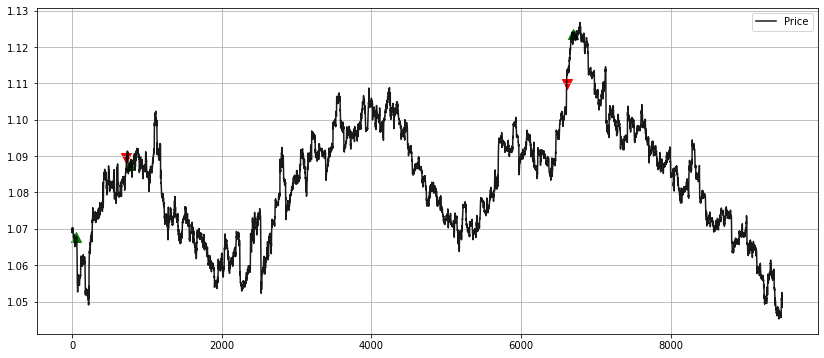

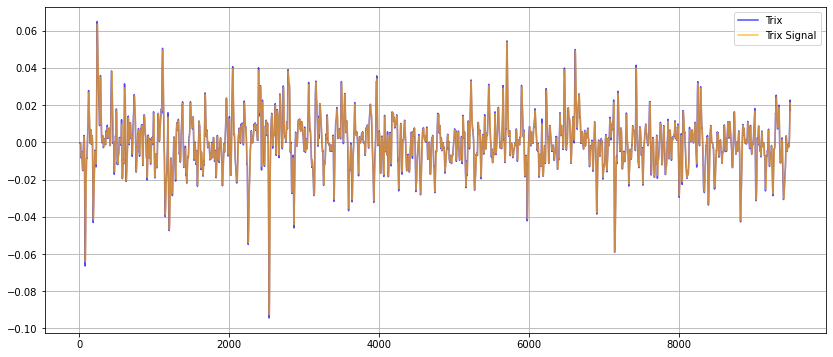

In [89]:




plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buysIndices].index, df.iloc[buysIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellsIndices].index, df.iloc[sellsIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(df.index, df['trix'], label='Trix', color='blue', alpha=0.7)
plt.plot(df.index, df['trixsignal'], label='Trix Signal', color='orange', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()

